<a href="https://colab.research.google.com/github/iroda1202/groheg/blob/main/hyperbolic_greedy_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dependencies
!pip install gmpy2

In [ ]:
#@title Imports
from typing import Optional, Dict, Tuple, List
import gmpy2
from gmpy2 import (mpfr,
                   fmod,
                   const_pi,
                   cosh,
                   sinh,
                   acosh,
                   cos,
                   acos,
                   copy_sign,
                   tan,
                   sqrt,
                   atanh,
                   sin)
import networkx as nx
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import sample
import itertools

In [ ]:
#@title Precision

# Setting the precision used when computing the embedding.
gmpy2.set_context(gmpy2.context())
gmpy2.get_context().precision = 300

In [ ]:
#@title Hyperbolic Geometry

class Polar:
  def __init__(self, r: Optional[mpfr] = None, phi: Optional[mpfr] = None):
    if r is None:
      self.set_radius(0)
    else:
      self.set_radius(r)

    if phi is None:
      self.set_angle(0)
    else:
      self.set_angle(phi)

  def __repr__(self):
    return f'Polar({self.r}, {self.phi})'

  def set_radius(self, radius: mpfr):
    self.r = radius

  def set_angle(self, angle: mpfr):
    self.phi = fmod(angle, 2.0 * const_pi())

    while self.phi < 0.0:
      self.phi += 2.0 * const_pi()

  def __eq__(self, other):
    return self.r == other.r and self.phi == other.phi

class HyperbolicPlane:
  @staticmethod
  def distance(p1: Polar, p2: Polar) -> Optional[mpfr]:
    if p1 == p2:
      return 0

    if p1.r == 0:
      return p2.r

    if p2.r == 0:
      return p1.r

    d_phi = const_pi() - abs(const_pi() - abs(p1.phi - p2.phi))

    return acosh(cosh(p1.r) * cosh(p2.r) - sinh(p1.r) * sinh(p2.r) * cos(d_phi))

  @staticmethod
  def rotated(p: Polar, angle: mpfr):
    return Polar(p.r, p.phi + angle)

  @staticmethod
  def translated(p: Polar, distance: mpfr):
    if distance == 0:
      return Polar(p.r, p.phi)

    if p.phi == 0.0:
      new_radius = abs(p.r + distance)
      new_angle = mpfr(0.0)
      if p.r + distance < 0.0:
        new_angle = const_pi()

      return Polar(new_radius, new_angle)

    if p.phi == const_pi():
      new_radius = abs(p.r - distance)
      new_angle = mpfr(0.0)
      if p.r - distance >= 0.0:
        new_angle = const_pi()

      return Polar(new_radius, new_angle)

    reference_radius = abs(distance)
    reference_angle = mpfr(0.0)
    if distance > 0:
      reference_angle = const_pi()

    reference_point = Polar(reference_radius, reference_angle)

    moving_angle = p.phi
    if moving_angle > const_pi():
      moving_angle = 2.0 * const_pi() - moving_angle
    moving_point = Polar(p.r, moving_angle)

    new_radius = HyperbolicPlane.distance(moving_point, reference_point)

    enumerator = (cosh(abs(distance)) * cosh(new_radius)) - cosh(p.r)
    denominator = sinh(abs(distance)) * sinh(new_radius)

    try:
      new_angle = acos(enumerator / denominator)
    except ValueError:
      if copy_sign(1, enumerator) == copy_sign(1, denominator):
        new_angle = 0.0
      else:
        new_angle = const_pi()
    except ZeroDivisionError:
      new_angle = 0.0

    if distance < 0.0:
      new_angle = const_pi() - new_angle

    if p.phi > const_pi():
      new_angle = 2.0 * const_pi() - new_angle

    return Polar(new_radius, new_angle)

  @staticmethod
  def distance_to_side_of_ideal_polygon(sides: int) -> mpfr:
    d = mpfr(sides)
    angle = const_pi() / d
    r = tan(angle)

    euclidean_distance = sqrt(1.0 + (r * r)) - r
    return 2.0 * atanh(euclidean_distance)

In [ ]:
#@title Spanning Trees

def betweenness_tree(graph: nx.Graph, root_id: str) -> nx.DiGraph:
  """
  Computes a spanning tree of the `graph` that maximizes the betweenness
  centralities of the edges.  The returned tree is rooted at the vertex with
  the `root_id`.
  """

  # Compute betweenness centralities for all edges.
  centralities = nx.edge_betweenness_centrality(graph)

  # Generate a weighted graph with the centralities as edge weights.
  weighted_edges = [(u, v, w) for ((u, v), w) in centralities.items()]
  weighted_graph = nx.Graph()
  weighted_graph.add_weighted_edges_from(weighted_edges)

  # Compute a spanning tree that maximizes the betweenness centralities.
  tree = nx.maximum_spanning_tree(weighted_graph)

  # This tree is not rooted so far. We compute a BFS tree of the tree (which
  # yields the same tree but rooted).
  return nx.bfs_tree(tree, root_id)

In [ ]:
#@title Embedding

def embed(graph: nx.Graph, tree: nx.DiGraph, root_id: str) -> Dict[str, Polar]:
  """
  Takes the `graph` to embed, a spanning `tree` of that graph and the ID of a
  node that should be considered the root of the tree as `root_id`.

  Returns a `Dict` where each key represents the ID of a note in the graph and
  maps to the `Polar` coordinate of the corresponding node in the embedding.
  """
  embedding = {}

  predecessors = {key: list(value.keys())[0] if len(list(value.keys())) > 0 else None for (key, value) in tree.pred.items()}
  successors = {key: list(value.keys()) for (key, value) in tree.succ.items()}


  def degree(node):
    if node not in successors:
      return 3

    return max(len(successors[node]), 2) + 1 # + 1 for the parent

  with tqdm(total=graph.number_of_nodes(), desc="Embedding") as pbar:

    embedding[root_id] = Polar()
    pbar.update(1)

    for node, children in successors.items():
      if predecessors[node] is None:
        # Embedding the children of the root.
        # print(f'Embedding: {children} of root {node}')

        root_degree = max(len(children), 3)
        angle = 2.0 * const_pi() / root_degree

        for index, child in enumerate(children):
          child_degree = degree(child)
          radius = 2.0 * HyperbolicPlane.distance_to_side_of_ideal_polygon(max(root_degree, child_degree))
          c = Polar(radius, angle * index)
          embedding[child] = c
          pbar.update(1)

        continue


      # Embedding children whose parent is not the root.
      n = embedding[node]

      parent = predecessors[node]
      p = embedding[parent]

      # print(f'Embedding: {children} of {node} with parent {parent}')

      # Move parent such that node lies on origin.
      rotation_angle = -n.phi
      translation_distance = -n.r

      p_rotated = HyperbolicPlane.rotated(p, rotation_angle)
      p_translated = HyperbolicPlane.translated(p_rotated, translation_distance)
      angle_p = -p_translated.phi

      node_degree = degree(node)
      angle = 2.0 * const_pi() / node_degree

      for index, child in enumerate(children):
        # Place the children as if the node lies on angle 0
        child_degree = degree(child)
        radius = 2.0 * HyperbolicPlane.distance_to_side_of_ideal_polygon(max(node_degree, child_degree))
        c = Polar(radius, angle * (index + 1)) # + 1 since the 0th angle is reserved for the parent.

        # Move the children to their actual positions.
        c_rotated = HyperbolicPlane.rotated(c, -angle_p)
        c_translated= HyperbolicPlane.translated(c_rotated, -translation_distance)
        c_final = HyperbolicPlane.rotated(c_translated, -rotation_angle)

        embedding[child] = c_final
        pbar.update(1)

  return embedding

In [ ]:
#@title Visualization

def visualize_embedding(graph: nx.Graph, tree: nx.DiGraph, embedding: Dict[str, Polar]):
  # Edge colors
  tree_edges = tree.edges()

  # Convert polar to Cartesian coordinates for visualization.
  positions = {node: (float(p.r * cos(p.phi)), float(p.r * sin(p.phi))) for (node, p) in embedding.items()}

  # Draw the graph.
  nx.draw_networkx_edges(graph,
                         pos=positions,
                         edge_color='black',
                         alpha=0.2)
  nx.draw_networkx_edges(graph,
                         pos=positions,
                         edgelist=tree_edges,
                         edge_color='red',
                         alpha=0.2)
  nx.draw_networkx_nodes(graph,
                         pos=positions,
                         node_size=1)
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')

In [ ]:
#@title Reading the Graph

graph = nx.read_edgelist("sample-graph.txt")
print(f'Read graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.')

root = "1"

Read graph with 1770 nodes and 8905 edges.


Embedding: 100%|██████████| 1770/1770 [00:00<00:00, 2142.41it/s]


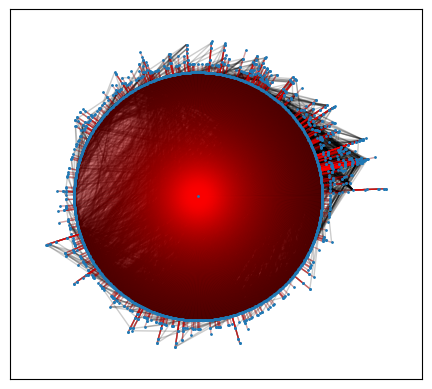

In [ ]:
#@title Embedding with BFS-Tree

# Computing the spanning tree
tree = nx.bfs_tree(graph, root)

# Computing the embedding
bfs_embedding = embed(graph, tree, root)

# Visualize
visualize_embedding(graph, tree, bfs_embedding)

Embedding: 100%|██████████| 1770/1770 [00:00<00:00, 3330.86it/s] 


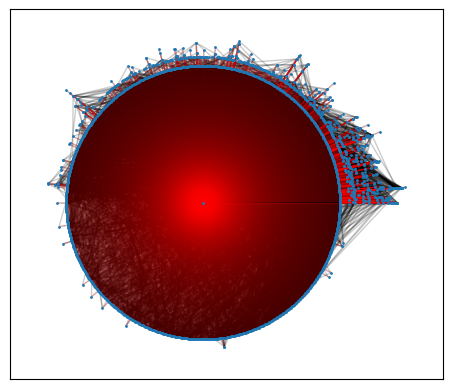

In [ ]:
#@title Embedding with Betwenness-Centrality-Tree

# Computing the spanning tree
tree = betweenness_tree(graph, root)

# Computing the embedding
betweenness_embedding = embed(graph, tree, root)

# Visualize
visualize_embedding(graph, tree, betweenness_embedding)

In [ ]:
#@title Evaluation

def get_greedy_path(source: str,
                    target: str,
                    graph: nx.Graph,
                    embedding: Dict[str, Polar]) -> List[str]:
  t = embedding[target]
  path = [source]

  # As long as the path does not end in the target, we route.
  while path[-1] != target:
    next = path[-1]
    next_distance = HyperbolicPlane.distance(embedding[next], t)

    for neighbor in graph.neighbors(path[-1]):
      neighbor_distance = HyperbolicPlane.distance(embedding[neighbor], t)

      if neighbor_distance < next_distance:
        next = neighbor
        next_distance = neighbor_distance

    # If the next node we found is the same node again, we are stuck in a dead end.
    if next == path[-1]:
      break;

    # Otherwhise, we append the next node to the path and continue routing.
    path.append(next)

  return path


def evaluate_embeddings(graph: nx.Graph,
                        embeddings: Dict[str, Dict[str, Polar]],
                        routing_samples = 1000) -> Tuple[Dict[str, float],
                                                         Dict[str, List[float]]]:
  """
  Evaluates how well greedy routing performs on the `graph` when using different
  embeddings.  The `embeddings` are passed as a dictionary that maps an
  identifier to the corresponding embedding (a map from vertices to `Polar`
  coordinates).  Evaluating all embeddings simultaneously has the advantage that
  that we can make fairer comparisons:  All embeddings are evaluated on the very
  same routes instead of sampling different routes for each embedding.

  For the evaluation we perform `routing_samples` many routings
  between randomly chosen sources and targets in the graph.  For each route and
  each embedding we determine whether we can route from the source to the target
  without getting stuck by using the coordinates of the vertices in the
  corresponding embedding as routing addresses.  Additionally, we compare the
  length of the routed path to a shortest path between the two vertices.

  Returns a `Tuple` of `Dict`s.  Each such dictionary maps the embedding
  identifiers to the results of the evaluation of the corresponding embedding.
  The first dictionary stores for each embedding a `float` that represent the
  fraction of routes where the target was found successfully when routing  with
  this embedding (success rate). The second dictionary stores for each embedding
  the `List` of stretch values, denoting for each routed path the relative
  length compared to a shortest path.

  Note that the `List`s containing the stretch values may not have the same size
  for all embeddings:  If we did not find a greedy path successfully, there is
  no greedy path that could be compared to a shortest path.  Hence there is no
  stretch value in that case.
  """

  potential_queries = list(itertools.combinations(list(graph.nodes), 2))
  queries = list(sample(potential_queries, routing_samples))

  success_full_routes = {identifier: 0 for identifier in embeddings.keys()}
  stretches = {identifier: [] for identifier in embeddings.keys()}

  for source, target in tqdm(queries):
    # Compute the length of a shortest path between source and target.
    shortest_path_length = nx.shortest_path_length(graph, source, target)

    # For every embedding, compute the greedy path between source and target.
    for identifier, embedding in embeddings.items():
      greedy_path = get_greedy_path(source,
                                    target,
                                    graph,
                                    embedding)

      if greedy_path[-1] == target:
        success_full_routes[identifier] += 1

        greedy_path_length = len(greedy_path) - 1 # -1 we want to count edges and not vertices.
        stretches[identifier].append(greedy_path_length / shortest_path_length)

  success_rates = {identifier: x / routing_samples for (identifier, x) in success_full_routes.items()}

  return (success_rates, stretches)


In [ ]:
#@title Running the Experiments


# Prepare input for evaluation.
embeddings = {'BFS': bfs_embedding,
              'Betweenness': betweenness_embedding}

# Evaluate...
(success_rates, stretches) = evaluate_embeddings(graph, embeddings)
print() # To get a line break after the progress bar.

# Print success rates.
for identifier, success_rate in success_rates.items():
  print(f'{identifier}: Success Rate: {success_rate * 100.0}%')

100%|██████████| 1000/1000 [01:13<00:00, 13.52it/s]



BFS: Success Rate: 100.0%
Betweenness: Success Rate: 100.0%


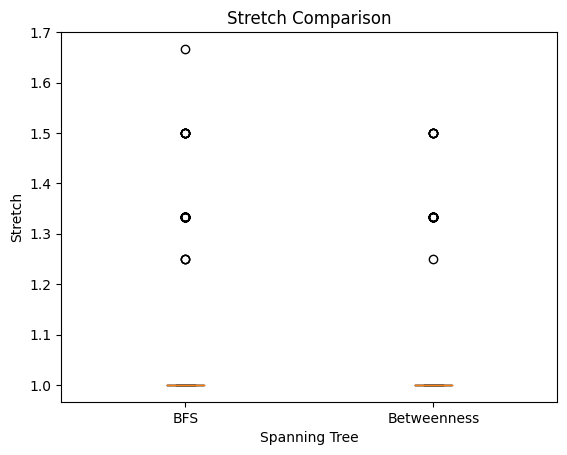

BFS: Average Stretch: 1.015416666666667
Betweenness: Average Stretch: 1.010916666666667


In [ ]:
# Plot the stretches.
fig, ax = plt.subplots()

# Draw box plots for the two datasets
ax.boxplot(stretches.values())

# Set the labels for the x-axis
ax.set_xticklabels(stretches.keys())

# Set the title and labels for the plot
ax.set_title('Stretch Comparison')
ax.set_xlabel('Spanning Tree')
ax.set_ylabel('Stretch')

# Show the plot
plt.show()

for identifier, stretch_values in stretches.items():
  average_stretch = sum(stretch_values) / len(stretch_values)
  print(f'{identifier}: Average Stretch: {average_stretch}')